In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

DATASET_COLUMNS  = ["Sentiment", "Id", "Date", "Flag", "User", "Text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Convert sentiment labels to binary (0: negative, 1: positive)
df['Sentiment'] = df['Sentiment'].replace({0: 0, 4: 1})

# Take 25% of data from each class
df_class_0 = df[df['Sentiment'] == 0].sample(frac=0.5, random_state=42)
df_class_1 = df[df['Sentiment'] == 1].sample(frac=0.5, random_state=42)

# Concatenate the samples
df_sampled = pd.concat([df_class_0, df_class_1])

# Shuffle the dataset
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the class distribution
print("Class '0':", len(df_class_0), "occurrences")
print("Class '1':", len(df_class_1), "occurrences")
print(df_sampled.head())

Class '0': 400000 occurrences
Class '1': 400000 occurrences
   Sentiment          Id                          Date      Flag  \
0          0  2187823903  Mon Jun 15 20:51:43 PDT 2009  NO_QUERY   
1          0  2208607104  Wed Jun 17 09:24:28 PDT 2009  NO_QUERY   
2          1  1979335935  Sun May 31 02:36:23 PDT 2009  NO_QUERY   
3          1  2014471354  Wed Jun 03 01:38:31 PDT 2009  NO_QUERY   
4          0  2016380491  Wed Jun 03 06:40:37 PDT 2009  NO_QUERY   

              User                                               Text  
0        a_drienne  @stockex yo are your allergies always this bad...  
1   InfinityEnds33          Great day off.  http://tinyurl.com/l5uy7a  
2        LLLLLaura                          ordered my new telephone   
3  KatieMcCullough  @naomijlea True, it is making me think of my s...  
4       andyhawkes  Anyone got any hints for migrating IMAP mail f...  


In [2]:
import pandas as pd
import re
import spacy
import swifter

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to clean and preprocess text using spaCy
def preprocess_text_spacy(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @ and # characters
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove special characters
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.text for token in doc if not token.is_stop]  # Remove stopwords
    return ' '.join(tokens)

# Apply the preprocessing function to the Text column using swifter for parallel processing
df_sampled['Text'] = df_sampled['Text'].swifter.apply(preprocess_text_spacy)

# Display the first few rows of the preprocessed dataset
print(df_sampled.head())


Pandas Apply:   0%|          | 0/800000 [00:00<?, ?it/s]

   Sentiment          Id                          Date      Flag  \
0          0  2187823903  Mon Jun 15 20:51:43 PDT 2009  NO_QUERY   
1          0  2208607104  Wed Jun 17 09:24:28 PDT 2009  NO_QUERY   
2          1  1979335935  Sun May 31 02:36:23 PDT 2009  NO_QUERY   
3          1  2014471354  Wed Jun 03 01:38:31 PDT 2009  NO_QUERY   
4          0  2016380491  Wed Jun 03 06:40:37 PDT 2009  NO_QUERY   

              User                                               Text  
0        a_drienne    yo allergies bad year friggen horrible n don...  
1   InfinityEnds33                                          great day  
2        LLLLLaura                              ordered new telephone  
3  KatieMcCullough    true making think script haven t touched gla...  
4       andyhawkes  got hints migrating imap mail dreamhost gmail ...  


## Tokenize and Pad the Text Data

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set parameters
vocab_size = 10000  # Maximum number of words to keep, based on word frequency
max_length = 100  # Maximum length of sequences (in terms of number of tokens)
trunc_type = 'post'  # Truncate sequences after the maximum length
padding_type = 'post'  # Pad sequences after the text

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df_sampled['Text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df_sampled['Text'])

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Display the shape of the padded sequences
print("Shape of padded sequences:", padded_sequences.shape)

# Convert sentiment labels to numpy array
labels = df_sampled['Sentiment'].values


Shape of padded sequences: (800000, 100)


## Split the Data into Training and Testing Sets

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (640000, 100) (640000,)
Testing set shape: (160000, 100) (160000,)


## Building an LSTM Model with an Attention Mechanism

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## Define the Attention Layer

In [10]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

## Define and Compile the Model

In [12]:
def create_model(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    attention = Attention()(lstm)
    dense1 = Dense(64, activation='relu')(attention)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define parameters
vocab_size = 10000
embedding_dim = 100
max_length = 100

# Create the model
model = create_model(vocab_size, embedding_dim, max_length)
model.summary()

C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,313 (4.23 MB)

 Trainable params: 1,109,313 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1083s 216ms/step - accuracy: 0.7104 - loss: 0.5385 - val_accuracy: 0.7834 - val_loss: 0.4551
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1088s 218ms/step - accuracy: 0.7909 - loss: 0.4481 - val_accuracy: 0.7846 - val_loss: 0.4537
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1005s 201ms/step - accuracy: 0.8004 - loss: 0.4290 - val_accuracy: 0.7862 - val_loss: 0.4534
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1042s 208ms/step - accuracy: 0.8104 - loss: 0.4103 - val_accuracy: 0.7833 - val_loss: 0.4607
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 962s 192ms/step - accuracy: 0.8201 - loss: 0.3909 - val_accuracy: 0.7815 - val_loss: 0.4754
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1057s 211ms/step - accuracy: 0.8312 - loss: 0.3699 - val_accuracy: 0.7771 - val_loss: 0.4953
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1080s 216ms/step - accuracy: 0.8423 - loss: 0.3467 - val_accuracy: 0.7736 - val_loss: 0.5219
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1024s 205ms/st

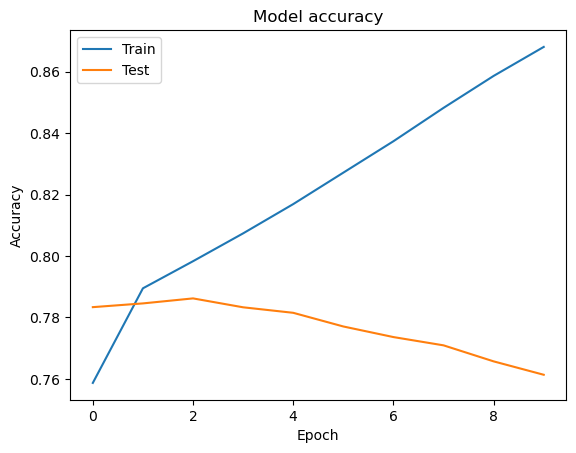

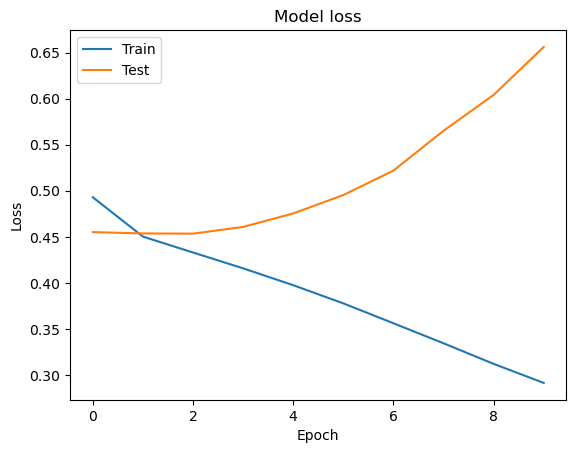

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=128)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Implementing Regularization and Early Stopping

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Redefine the model with more regularization
def create_model_with_regularization(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(embedding)
    attention = Attention()(lstm)
    dense1 = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(attention)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model with regularization
model_with_reg = create_model_with_regularization(vocab_size, embedding_dim, max_length)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history_with_reg = model_with_reg.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=128, callbacks=[early_stopping])

# Plot training & validation accuracy values
plt.plot(history_with_reg.history['accuracy'])
plt.plot(history_with_reg.history['val_accuracy'])
plt.title('Model accuracy with regularization and early stopping')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_with_reg.history['loss'])
plt.plot(history_with_reg.history['val_loss'])
plt.title('Model loss with regularization and early stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 951s 189ms/step - accuracy: 0.4996 - loss: 0.8583 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 967s 193ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 995s 199ms/step - accuracy: 0.4998 - loss: 0.6932 - val_accuracy: 0.4997 - val_loss: 0.6932
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1138s 228ms/step - accuracy: 0.4986 - loss: 0.6932 - val_accuracy: 0.5003 - val_loss: 0.6931
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1200s 240ms/step - accuracy: 0.4997 - loss: 0.6932 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1308s 262ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.4997 - val_loss: 0.6932
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1169s 234ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5003 - val_loss: 0.6931
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1338s 268ms/step

KeyboardInterrupt: 

### Adjusting Learning Rate and Simplifying Model

C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1074s 214ms/step - accuracy: 0.6340 - loss: 0.6123 - val_accuracy: 0.7614 - val_loss: 0.4902
Epoch 2/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1141s 228ms/step - accuracy: 0.7756 - loss: 0.4801 - val_accuracy: 0.7773 - val_loss: 0.4691
Epoch 3/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1249s 250ms/step - accuracy: 0.7799 - loss: 0.4700 - val_accuracy: 0.7770 - val_loss: 0.4660
Epoch 4/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1138s 228ms/step - accuracy: 0.7818 - loss: 0.4635 - val_accuracy: 0.7782 - val_loss: 0.4711
Epoch 5/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1165s 233ms/step - accuracy: 0.7854 - loss: 0.4578 - val_accuracy: 0.7749 - val_loss: 0.4660
Epoch 6/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1188s 238ms/step - accuracy: 0.7878 - loss: 0.4519 - val_accuracy: 0.7810 - val_loss: 0.4608
Epoch 7/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 53960s 11s/step - accuracy: 0.7896 - loss: 0.4462 - val_accuracy: 0.7796 - val_loss: 0.4630
Epoch 8/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1247s 249ms/st

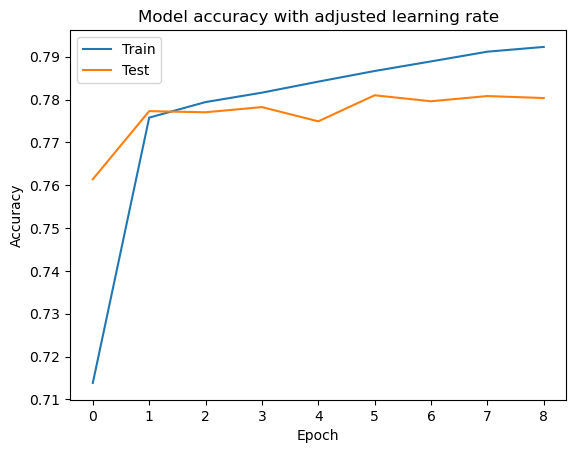

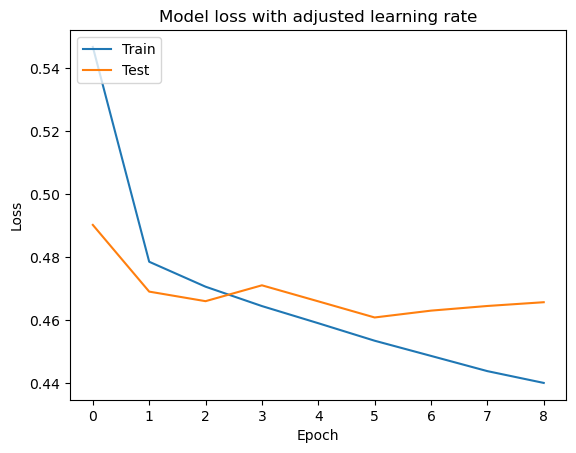

In [18]:
from tensorflow.keras.optimizers import Adam

# Adjust the learning rate
learning_rate = 0.0001  # Lower learning rate
optimizer = Adam(learning_rate=learning_rate)

# Redefine the model with adjusted learning rate
def create_model_adjusted_lr(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    attention = Attention()(lstm)
    dense1 = Dense(64, activation='relu')(attention)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model with adjusted learning rate
model_adjusted_lr = create_model_adjusted_lr(vocab_size, embedding_dim, max_length)

# Train the model with early stopping
history_adjusted_lr = model_adjusted_lr.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=128, callbacks=[early_stopping])

# Plot training & validation accuracy values
plt.plot(history_adjusted_lr.history['accuracy'])
plt.plot(history_adjusted_lr.history['val_accuracy'])
plt.title('Model accuracy with adjusted learning rate')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_adjusted_lr.history['loss'])
plt.plot(history_adjusted_lr.history['val_loss'])
plt.title('Model loss with adjusted learning rate')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 3726s 372ms/step - accuracy: 0.6277 - loss: 0.6857 - val_accuracy: 0.7683 - val_loss: 0.4872
Epoch 2/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1285s 128ms/step - accuracy: 0.7732 - loss: 0.4871 - val_accuracy: 0.7672 - val_loss: 0.4923
Epoch 3/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1254s 125ms/step - accuracy: 0.7787 - loss: 0.4754 - val_accuracy: 0.7760 - val_loss: 0.4734
Epoch 4/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1375s 138ms/step - accuracy: 0.7815 - loss: 0.4679 - val_accuracy: 0.7782 - val_loss: 0.4694
Epoch 5/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1296s 130ms/step - accuracy: 0.7836 - loss: 0.4627 - val_accuracy: 0.7785 - val_loss: 0.4715
Epoch 6/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1306s 131ms/step - accuracy: 0.7873 - loss: 0.4565 - val_accuracy: 0.7791 - val_loss: 0.4689
Epoch 7/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1506s 151ms/step - accuracy: 0.7888 - loss: 0.4537 - val_accuracy: 0.7800 - val_loss: 0.4677
Epoch 8/30
10000/10000 ━━━━━━━━━━━━━━━━━━

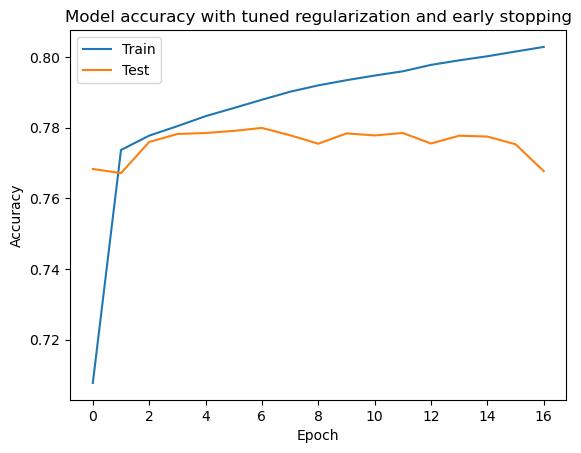

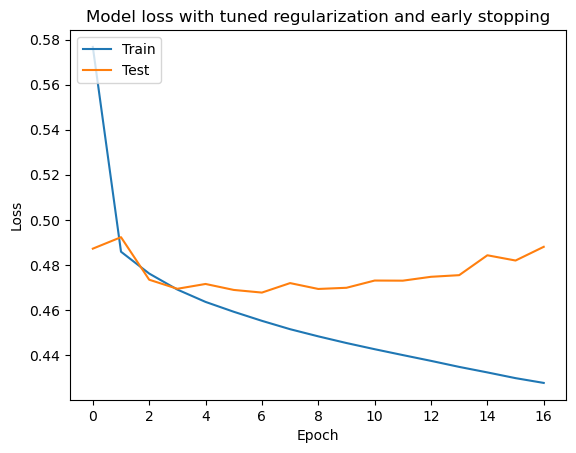

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Redefine the model with adjusted regularization
def create_model_with_tuned_regularization(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))(embedding)
    attention = Attention()(lstm)
    dense1 = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model with tuned regularization
tuned_model = create_model_with_tuned_regularization(vocab_size, embedding_dim, max_length)

# Define early stopping callback with increased patience
early_stopping_tuned = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with tuned regularization and early stopping
history_tuned = tuned_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping_tuned])

# Plot training & validation accuracy values
plt.plot(history_tuned.history['accuracy'])
plt.plot(history_tuned.history['val_accuracy'])
plt.title('Model accuracy with tuned regularization and early stopping')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_tuned.history['loss'])
plt.plot(history_tuned.history['val_loss'])
plt.title('Model loss with tuned regularization and early stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Step 1: Further Reduce Regularization Strength and Increase Dropout Rate

In [23]:
# Redefine the model with further reduced regularization and increased dropout
def create_model_with_further_tuned_regularization(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001)))(embedding)
    attention = Attention()(lstm)
    dense1 = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(attention)
    dropout = Dropout(0.6)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model with further tuned regularization
further_tuned_model = create_model_with_further_tuned_regularization(vocab_size, embedding_dim, max_length)

# Define early stopping callback with increased patience
early_stopping_further_tuned = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with further tuned regularization and early stopping
history_further_tuned = further_tuned_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping_further_tuned])

# Plot training & validation accuracy values
plt.plot(history_further_tuned.history['accuracy'])
plt.plot(history_further_tuned.history['val_accuracy'])
plt.title('Model accuracy with further tuned regularization and early stopping')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_further_tuned.history['loss'])
plt.plot(history_further_tuned.history['val_loss'])
plt.title('Model loss with further tuned regularization and early stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1463s 145ms/step - accuracy: 0.6162 - loss: 0.6429 - val_accuracy: 0.7699 - val_loss: 0.4909
Epoch 2/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1585s 158ms/step - accuracy: 0.7736 - loss: 0.4942 - val_accuracy: 0.7750 - val_loss: 0.4783
Epoch 3/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1561s 156ms/step - accuracy: 0.7782 - loss: 0.4832 - val_accuracy: 0.7754 - val_loss: 0.4763
Epoch 4/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1522s 152ms/step - accuracy: 0.7801 - loss: 0.4791 - val_accuracy: 0.7710 - val_loss: 0.4780
Epoch 5/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1586s 159ms/step - accuracy: 0.7808 - loss: 0.4757 - val_accuracy: 0.7761 - val_loss: 0.4720
Epoch 6/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1495s 150ms/step - accuracy: 0.7820 - loss: 0.4706 - val_accuracy: 0.7778 - val_loss: 0.4707
Epoch 7/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1511s 151ms/step - accuracy: 0.7843 - loss: 0.4673 - val_accuracy: 0.7780 - val_loss: 0.4705
Epoch 8/30
10000/10000 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

### Step 2: Add Batch Normalization

C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1343s 134ms/step - accuracy: 0.7088 - loss: 0.5753 - val_accuracy: 0.6238 - val_loss: 0.8090
Epoch 2/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1614s 161ms/step - accuracy: 0.7749 - loss: 0.4923 - val_accuracy: 0.7754 - val_loss: 0.4806
Epoch 3/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1413s 141ms/step - accuracy: 0.7772 - loss: 0.4843 - val_accuracy: 0.7761 - val_loss: 0.4852
Epoch 4/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1363s 136ms/step - accuracy: 0.7793 - loss: 0.4776 - val_accuracy: 0.7564 - val_loss: 0.4992
Epoch 5/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1459s 146ms/step - accuracy: 0.7821 - loss: 0.4703 - val_accuracy: 0.7671 - val_loss: 0.4868
Epoch 6/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1622s 162ms/step - accuracy: 0.7843 - loss: 0.4655 - val_accuracy: 0.7713 - val_loss: 0.4827
Epoch 7/30
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1462s 146ms/step - accuracy: 0.7873 - loss: 0.4600 - val_accuracy: 0.7789 - val_loss: 0.4742
Epoch 8/30
10000/10000 ━━━━━━━━━━━━━━━━━━

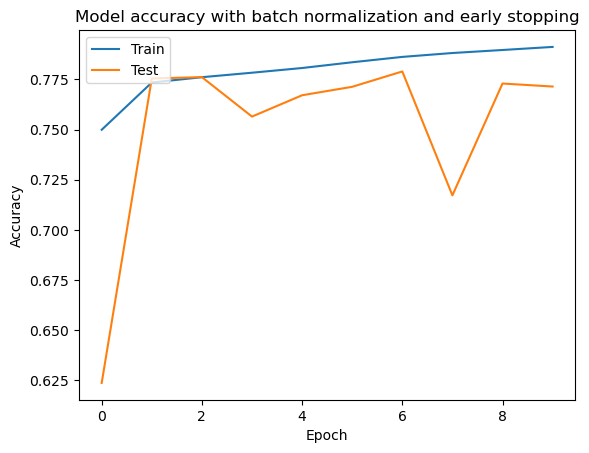

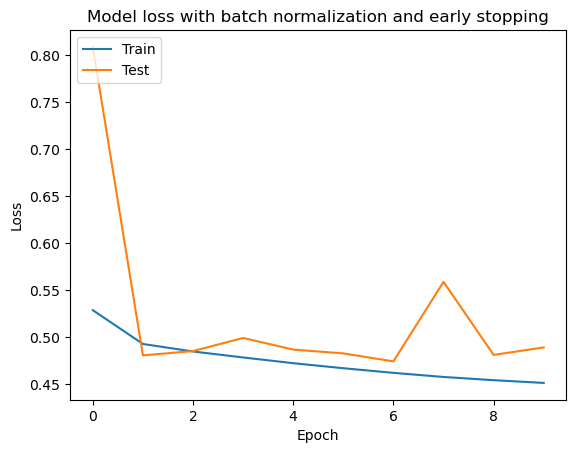

In [26]:
from tensorflow.keras.layers import BatchNormalization

# Redefine the model with batch normalization
def create_model_with_batch_normalization(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001)))(embedding)
    batch_norm = BatchNormalization()(lstm)
    attention = Attention()(batch_norm)
    dense1 = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(attention)
    dropout = Dropout(0.6)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model with batch normalization
batch_norm_model = create_model_with_batch_normalization(vocab_size, embedding_dim, max_length)

# Train the model with batch normalization and early stopping
history_batch_norm = batch_norm_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping_further_tuned])

# Plot training & validation accuracy values
plt.plot(history_batch_norm.history['accuracy'])
plt.plot(history_batch_norm.history['val_accuracy'])
plt.title('Model accuracy with batch normalization and early stopping')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_batch_norm.history['loss'])
plt.plot(history_batch_norm.history['val_loss'])
plt.title('Model loss with batch normalization and early stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
